Built on lecture slides from [Jeremy Bejarano](https://github.com/jmbejara/bfi-reu-2019)

# Fits Static Entry Model
This notebook implements an example, showing how to fit the model from [Bresnahan and Reiss (1991)](https://www.jstor.org/stable/2937655) on a data sample from the refrigerated trucking industry in California. 

## Description of the Data

Each observation is a "market." These are cities and other Census-designated places in California where there is at least one TRU company registered in the ARBER dataset. 

The data included in the sample has 400 rows, including the following variables:

  - `NAME`: The town name. 
  - `num_firms`: The number of incumbent TRU firms in the market, from [2023 ARBER dataset](https://arber.arb.ca.gov/publicTruSearch.arb). 
  - `households`: Town population, in households. From 2020 American Community Survey. 
  - `mean_income`: Mean household income. From 2020 American Community Survey. 
  - `land_value`: Measure of the land value per quarter-acre, as estimated by [Davis et al. (2021)](https://www.sciencedirect.com/science/article/pii/S0304393220301379) 
  - `property_value`: Measure of property value, from above source. 
  - `diesel`: Average diesel price in the MSA, from [AAA](https://gasprices.aaa.com/?state=CA)
  - `44-45_RCPTOT`: Total sales and receipts from Retail Trade. From 2017 Economic Census. 
  - `72_RCPTOT`: Total sales and receipts from accommodation and food services. From 2017 Economic Census. 


Of these, we assume that the size of a market is a linear combination of the total income (`mean income * num_households`) and total sales and receipts (from both `44-45_RCPTOT`and `72_RCPTOT`). We assume that land value shifts the fixed costs of a firm operating, and diesel shifts the variable costs. 

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import os
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline
# import seaborn as sns
import scipy.stats
import scipy.optimize
import mapclassify
from sklearn.preprocessing import StandardScaler

In [2]:
filename = '../data/overall_data.csv'
df = pd.read_csv(filename)
df['total_income'] = df['households'] * df['mean_income']
relevant_vars = ['diesel','land_value','total_income','44-45_RCPTOT','72_RCPTOT', 'num_firms']
subset = df.dropna(subset=relevant_vars)
subset[['land_value','total_income','44-45_RCPTOT','72_RCPTOT', 'diesel']] = StandardScaler().fit_transform(subset[['land_value','total_income','44-45_RCPTOT','72_RCPTOT', 'diesel']])
subset

,clean_city,NAME,NAMELSAD,num_firms,44-45_RCPTOT,72_RCPTOT,31-33_RCPTOT,median_income,households,mean_income,land_value,property_value,diesel,total_income
0,adelanto,Adelanto,Adelanto city,2.0,-0.333793,-0.245393,371799.0,58040.0,8451.0,66318.0,-0.848190,1.871184e+05,-0.790614,-0.247698
2,alhambra,Alhambra,Alhambra city,6.0,0.326895,0.037790,NaN,73035.0,30057.0,93467.0,0.308894,7.627309e+05,0.314127,0.029100
3,aliso viejo,Aliso Viejo,Aliso Viejo city,1.0,-0.220588,-0.118233,NaN,122320.0,18999.0,144493.0,0.586952,8.617360e+05,-1.020432,0.021208
6,american canyon,American Canyon,American Canyon city,4.0,-0.278499,-0.228766,NaN,117846.0,5540.0,140821.0,-0.560387,4.700324e+05,1.465235,-0.220657
7,anaheim,Anaheim,Anaheim city,10.0,1.155069,2.710158,4511272.0,81806.0,103570.0,103011.0,0.131787,7.027949e+05,-1.020432,0.996465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,NaN,NaN,Winter Gardens CDP,0.0,-0.324087,-0.241491,NaN,79099.0,7727.0,96543.0,-0.453539,4.830929e+05,-0.824885,-0.224862
855,NaN,NaN,Woodbridge CDP,0.0,-0.352340,-0.257604,NaN,117760.0,1520.0,131866.0,-0.605844,3.582511e+05,-0.589019,-0.292010
858,NaN,NaN,Wrightwood CDP,0.0,-0.353842,-0.253957,NaN,54240.0,1997.0,96791.0,-0.694890,3.200986e+05,-0.790614,-0.292889
860,NaN,NaN,Yountville city,0.0,-0.346182,-0.074995,NaN,68611.0,1606.0,111813.0,0.628838,1.150821e+06,1.465235,-0.294578


In [3]:
subset[relevant_vars + ['NAMELSAD']].to_csv('../data/estimation_subset.csv', index=False)

In [4]:
subset.drop(['clean_city','NAME','NAMELSAD'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
num_firms,525.0,7.249524e+00,3.168187e+01,0.000000,0.000000,1.000000,4.000000e+00,4.580000e+02
44-45_RCPTOT,525.0,2.706829e-17,1.000954e+00,-0.356871,-0.337278,-0.255751,5.225661e-02,1.757807e+01
72_RCPTOT,525.0,0.000000e+00,1.000954e+00,-0.259893,-0.241491,-0.181870,-3.037957e-02,1.639925e+01
31-33_RCPTOT,189.0,2.193140e+06,4.436653e+06,1539.000000,262590.000000,868749.000000,1.994235e+06,3.945559e+07
median_income,525.0,9.283351e+04,3.665600e+04,22386.000000,67549.000000,85628.000000,1.097500e+05,2.489840e+05
households,525.0,2.151871e+04,7.018753e+04,63.000000,3675.000000,8926.000000,2.298400e+04,1.384851e+06
mean_income,525.0,1.207810e+05,5.263755e+04,32936.000000,85577.000000,107755.000000,1.413500e+05,3.454780e+05
land_value,525.0,6.767074e-17,1.000954e+00,-0.870798,-0.679145,-0.313651,3.431152e-01,8.377496e+00
property_value,525.0,6.555394e+05,4.307255e+05,109700.000000,326906.800518,568541.541494,8.327263e+05,3.299083e+06
diesel,525.0,2.135012e-15,1.000954e+00,-2.990016,-0.824885,0.314127,7.193328e-01,2.781650e+00


## Model Description

Following the structure of equation (4), we assume that 

$$
\Pi_N = \bar \Pi_N + \epsilon = S(Y, \lambda) V_N(Z, W, \alpha, \beta) - F_N(W, \gamma) + \epsilon, \tag{8}
$$

where $\lambda$, $\alpha$, $\beta$, and $\gamma$ represent profit function parameters, $Y$ describes market size, $Z$ and $W$ shift per capita demand and costs, and the error term $\epsilon$ summarizes unobserved influences on profits. To simplify the estimation procedure, we assume that $\epsilon$ has a standard normal distribution that is independently distributed across markets and is independent of our observables ($\epsilon \sim \mathcal N(0,1)$). We also assume that $\epsilon$ has zero mean and a constant variance and that each firm within a market has the same profit error. This last assumption presumes that successive entrants' profits differ only through the determinist variables in (8). Notice that we use $\bar \Pi_N$ to represent this deterministic portion of profits.


### Probability
Now, how do we calculate the likelihood function of this model? Notice that since we don't observe $\Pi$, we won't be able to calculate residuals to plug into our MLE procedure. In the case of estimating a linear regression equation with MLE, we calculated residuals and plugged those residuals into a PDF. In our case, we can't do that. Instead, we can only use our data to *put bounds on epsilon*. Consider what is implied when we observe no firms in a market. If there are no firms, then this implies that the per-firm profits of one firm would be less than zero, $\Pi_1 < 0$. Let's use a little algebra to see what this implies about epsilon:

\begin{gather*}
\Pi_1 < 0 \\
\Pi_1 = \bar \Pi_1 + \epsilon < 0 \\
\epsilon < -\bar \Pi_1 
\end{gather*}

Now that we see what this implies about epsilon, since we have assumed a distribution for epsilon, we can calculate what the probability (likelihood) of this occuring. The probability of observing markets with no firms equals

\begin{align*}
P(\Pi_1 < 0) &=  P(\epsilon < -\bar \Pi_1 ) \\
  &= \Phi(-\bar \Pi_1) \\
  &= 1 - \Phi(\bar \Pi_1)
\end{align*}

where $\Phi(\cdot)$ is the cumulative normal distribution function, and $\Pi_1 = \bar \Pi_1 + \epsilon$ equals a monopolist's profits. 

If $\bar \Pi_1 \geq \bar \Pi_2 \geq ... \geq \bar \Pi_\overline{N}$, the probability of observing $N$ firms in equilibrium ( $N = 1,2,3, ... $ ) equals

$$
P(\Pi_n \geq 0 \text{ and } \Pi_{n+1} < 0) = \Phi(\bar \Pi_n) - \Phi(\bar \Pi_{n+1}).
$$

The residual probability of observing $N$ or more firms equals

$$
P(\Pi_\overline{N} \geq 0) = \Phi(\bar \Pi_\overline{N}).
$$


### Market Size and Variable Profit
Market size is modeled as a linear function of population variables and size of related industries. Specifically, we assume that

$$
S(Y, \lambda) = \lambda_1 \text{total_income} + \lambda_2 \text{44-45_RCPTOT} + \lambda_3 \text{72_RCPTOT}. \tag 9
$$

We set the coefficient of town population is $S(Y, \lambda)$ equal to one because $V_N$ contains a constant term. This normalization translates units of market demand into units of current town population.

We model firms' per capita variable profits, $V_N$ , as a function of the number of firms, $N$, and economic variables, $X = [W, Z].$ We assume that this function has the linear form

$$V_N = -\alpha_1 + \mathbf X \beta - \sum_{n=2}^N \alpha_n. \tag{10}$$

The term $V_N = \alpha_1 + \mathbf X \beta $ equal the per capita variable profit of a monopolist. 
We calibrate $\alpha_1$ to 400,000, to match the typical cost of sales from a small business in long-distance trucking, as reported by the Bizminer financial report. 
Ideally, this would be the cost of sales from an average business in local refrigerated trucking; we did not pull the Bizminer request for this industry.

### Fixed Costs
Because we do not have detailed information on costs, we assume

$$ 
F_N = \gamma_1 W_0 + \gamma_L W_L + \sum_{n=2}^N \gamma_n.
$$

The term $F_1 = \gamma_1 W_0 + \gamma_L W_L$ equals a monopolist's fixed costs. We calibrate $W_0$ to 800,000, to match the typical operating expenses of a small business in long-distance trucking, from Bizminer's financial report. 


We include the price of land to capital intermarket variation in land costs. The $\gamma_n$ terms allow later entrants to have higher costs. When we observe $\gamma_n$ greater than zero, we conclude that later entrants have higher fixed costs. We do not known, however, whether these higher costs mean that the entran is less efficient (i.e., the supply curve of entrants is upward sloping) or it faces entry barriers.

### Log Likelihood

The log-likelihood function $\mathcal L$ is given by

$$
\mathcal L = \sum_{i=1}^I  \left( 
\mathbb 1\{N_i = 0\} \log P \left( \Pi_1^i < 0 \right) + 
\mathbb 1\{N_i \geq \overline{N}\} \log P \left(\Pi_N^i \geq 0\right) +
\sum_{j=1}^{\overline{N}-1} \mathbb 1\{N_i=j\}  \log P \left(\Pi^i_{N_i} \geq 0 \text{ and } \Pi^i_{N_i+1} < 0\right) 
\right), 
$$

$$
$$

for observations $i=1,...,I$. Note that the values of $\Pi^i_{N_i}$ depend on the characteristics of a particular market ($W_i$, $Y_i$, $Z_i$) and the number of incumbents $N_i$ in market $i$.

$\overline{N}$ is the maximum modeled number of firms; we set this to 10. Beyond this value, we do not have sufficient observations to estimate parameters. 

In [5]:
max_N = 5
weighted = True

def V(df, Ni, alpha=np.ones(max_N ), beta=1):
    """Variable profit
    
    As a function of the market size. 
    
    df: data
    Ni: number of incumbents in market i
    alpha: alpha parameters
    beta: beta parameters
    """
    n = np.min([max_N, Ni])
    
    profit = df['diesel'] * beta - np.sum(alpha[1:n ]) + alpha[0]
    return profit

def F(df, Ni, gamma=np.ones(max_N), W_L = 1):
    n = np.min([max_N, Ni])
    
    fixed_cost = np.sum(gamma[1:n]) + df['land_value'] * W_L + gamma[0]
    return fixed_cost


def S_func(df, lam=np.ones(3)):
    return 1 + df[['total_income','44-45_RCPTOT', '72_RCPTOT']] @ lam
#     S = dTPOP + lam[0] * df.OPOP + lam[1] * df.NGRW + 
#          lam[2] * df.PGRW + lam[3] * df.OCTY)
#     return S

def neg_log_lik(theta=np.ones(5 + 2 * max_N), df=None, weighted=weighted):
    lam = theta[0:3]
    alpha = theta[3: 3 + max_N]
    gamma = theta[3 + max_N: 3 + 2 * max_N]
    beta = theta[3 + 2* max_N: 4 + 2* max_N]
    W_L = theta[4 + 2* max_N: 5 + 2* max_N]
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam)

    with np.errstate(divide='ignore'): # Dividing by zero is anticipated. 
        P = [0] * (max_N + 1)
        Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma, W_L=W_L)
        P[0] = np.log( 1 - Phi(Pi_bar(1)) )
        P[max_N] = np.log( Phi(Pi_bar(max_N)) )
        for i in range(1,max_N):
            P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )

        for i in range(max_N + 1):
            P[i][P[i] == -np.inf] = -100000000
            P[i][P[i] == np.inf] = 100000000
        log_lik = 0 
        weighting_factor = [1 / np.sum(df['num_firms'] == i) for i in range(max_N)] + \
                        [1 / np.sum(df['num_firms'] >= max_N)] \
                        if weighted else np.ones(max_N + 1)
        for i in range(max_N):
            log_lik = log_lik + np.sum(P[i] * (df['num_firms'] == i)) * weighting_factor[i]
        log_lik = log_lik + np.sum(P[max_N] * (df['num_firms'] >= max_N)) * weighting_factor[max_N]
    return -log_lik
def theta_to_param_dict(theta):
    lam = theta[0:3]
    alpha = theta[3: 3 + max_N]
    gamma = theta[3 + max_N: 3 + 2 * max_N]
    beta = theta[3 + 2* max_N: 4 + 2* max_N]
    W_L = theta[4 + 2* max_N: 5 + 2* max_N]
#     lam = theta[0:3]
#     alpha = theta[3: 2 + max_N]
#     gamma = theta[2 + max_N: 2 + 2 * max_N]
#     beta = theta[2 + 2* max_N: 3 + 2* max_N]
#     W_L = theta[3 + 2* max_N: 4 + 2* max_N]
    
    d = {'lam': lam, 'alpha': alpha, 'gamma': gamma, 'beta': beta, 'W_L':W_L, 'theta':theta}
    return d
lower_bounds = [0] * 3 + [0] * (2 * max_N ) + [-np.inf] * 2
theta_size = len(lower_bounds)
upper_bounds = [np.inf] * theta_size
bounds = list(zip(lower_bounds, upper_bounds))
nll = lambda theta: neg_log_lik(theta=theta, df=subset)
nll(1e-2 * np.ones(theta_size))

20.77973937108965

In [6]:
initial_params = []
neg_likelihood = []
best_model = None
for param in np.logspace(-4, 1, 21):
    initial_guess = param * np.ones(theta_size)
    out = scipy.optimize.minimize(nll, initial_guess, 
                                  options={'disp':False, 'maxiter':30000}, bounds=bounds)
    initial_params.append(param)
    neg_likelihood.append(out.fun)
    if out.fun == np.min(neg_likelihood):
        best_model = out

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223.py:49: RuntimeWarning: invalid value encountered in log
  P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18421/1155783223

In [7]:
best_model

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 9.659632107775973
        x: [ 4.397e-01  5.794e-01 ...  3.054e-02  5.764e-01]
      nit: 82
      jac: [-1.847e-05 -2.629e-05 ... -5.151e-06  7.603e-05]
     nfev: 1392
     njev: 87
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>

In [8]:
min_param = initial_params[neg_likelihood.index(np.min(neg_likelihood))]
print("Loss minimized at", min_param)

Loss minimized at 0.005623413251903491


In [10]:
param_dict = theta_to_param_dict(best_model.x)
param_dict

{'lam': array([0.43968942, 0.57942966, 0.52069767]),
 'alpha': array([2.2854546 , 0.8607274 , 0.        , 0.        , 0.55509788]),
 'gamma': array([0.87274384, 0.        , 0.5131407 , 0.51717757, 0.06483591]),
 'beta': array([0.03054308]),
 'W_L': array([0.57636756]),
 'theta': array([0.43968942, 0.57942966, 0.52069767, 2.2854546 , 0.8607274 ,
        0.        , 0.        , 0.55509788, 0.87274384, 0.        ,
        0.5131407 , 0.51717757, 0.06483591, 0.03054308, 0.57636756])}

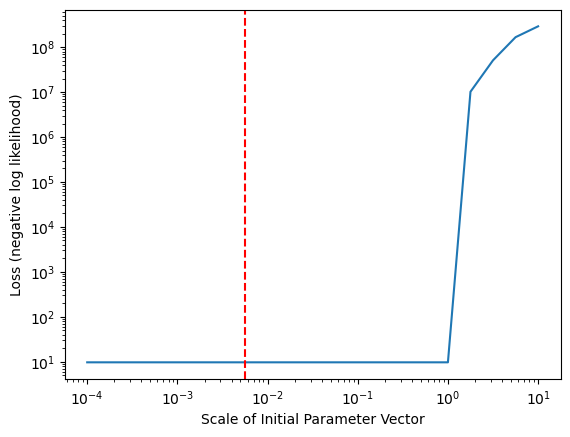

In [11]:
fig, ax = plt.subplots()
plt.plot(initial_params, neg_likelihood)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(bottom=None, top=15)
ax.set_ylabel('Loss (negative log likelihood)')
ax.set_xlabel('Scale of Initial Parameter Vector')
ax.axvline(min_param, linestyle='--', color='red')